# **0. Import library**

In [1]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
from datetime import datetime, timedelta
import re
import squarify

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

%matplotlib inline


# **1. Import data**

In [3]:
!wget 'https://raw.githubusercontent.com/Giangvo55/final-project-DAwP/main/data/Olist_Master.csv'

--2022-06-08 09:04:08--  https://raw.githubusercontent.com/Giangvo55/final-project-DAwP/main/data/Olist_Master.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47814793 (46M) [text/plain]
Saving to: ‘Olist_Master.csv’

Olist_Master.csv    100%[===================>]  45.60M   196MB/s    in 0.2s    

2022-06-08 09:04:09 (196 MB/s) - ‘Olist_Master.csv’ saved [47814793/47814793]



In [4]:
data = pd.read_csv('Olist_Master.csv')

# **2. Data pre-processing**

## 2.1 Understand the content of the data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116581 entries, 0 to 116580
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       116581 non-null  object 
 1   order_item_id                  116581 non-null  int64  
 2   product_id                     116581 non-null  object 
 3   seller_id                      116581 non-null  object 
 4   shipping_limit_date            116581 non-null  object 
 5   price                          116581 non-null  float64
 6   freight_value                  116581 non-null  float64
 7   payment_sequential             116581 non-null  int64  
 8   payment_type                   116581 non-null  object 
 9   payment_installments           116581 non-null  int64  
 10  payment_value                  116581 non-null  float64
 11  product_category_name          116581 non-null  object 
 12  seller_zip_code_prefix        

In this dataset, we have 102425 of historical order from 2016 - 2018 in Brazil E-commrce website Olist

Let's see first 5 rows of dataset

In [6]:
data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,...,customer_city,customer_state,customer_unique_id,review_response_time,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,1,Credit Card,2,...,Campos Dos Goytacazes,RJ,5ee8fe956c2631afc0a1dcc1920d0e3d,1,2017,9,2,8,Wed,Sep
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,1,Boleto,1,...,Jatai,GO,8b3f917f4307d3e5cf34c0b43d6e6f50,3,2017,6,2,11,Wed,Jun
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,1,Credit Card,2,...,Belo Horizonte,MG,69ba88e17ea574da9c9b8c8834a583d1,1,2018,5,4,10,Fri,May
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,1,Credit Card,3,...,Sao Jose Dos Pinhais,PR,cbe063493a222cb17024ff0285b4ecb6,3,2017,8,1,18,Tue,Aug
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,1,Credit Card,4,...,Conselheiro Lafaiete,MG,ffab5330bd7b40979ab6726b2e02292e,3,2017,8,3,21,Thu,Aug


First, we get some columns that we need for our next steps such as: customer_id, order_id, order_status, order_purchase_timestamp, product_id, qty, price. 

In [7]:
df_orders = data[['order_id', 'order_status', 'order_purchase_timestamp',
       'payment_value', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state']].copy()

In [8]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116581 entries, 0 to 116580
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  116581 non-null  object 
 1   order_status              116581 non-null  object 
 2   order_purchase_timestamp  116581 non-null  object 
 3   payment_value             116581 non-null  float64
 4   customer_unique_id        116581 non-null  object 
 5   customer_zip_code_prefix  116581 non-null  int64  
 6   customer_city             116581 non-null  object 
 7   customer_state            116581 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 7.1+ MB


In [9]:
df_orders

,order_id,order_status,order_purchase_timestamp,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,delivered,2017-09-13 08:59:02,72.19,5ee8fe956c2631afc0a1dcc1920d0e3d,28013,Campos Dos Goytacazes,RJ
1,130898c0987d1801452a8ed92a670612,delivered,2017-06-28 11:52:20,73.86,8b3f917f4307d3e5cf34c0b43d6e6f50,75800,Jatai,GO
2,532ed5e14e24ae1f0d735b91524b98b9,delivered,2018-05-18 10:25:53,83.23,69ba88e17ea574da9c9b8c8834a583d1,30720,Belo Horizonte,MG
3,6f8c31653edb8c83e1a739408b5ff750,delivered,2017-08-01 18:38:42,75.07,cbe063493a222cb17024ff0285b4ecb6,83070,Sao Jose Dos Pinhais,PR
4,7d19f4ef4d04461989632411b7e588b9,delivered,2017-08-10 21:48:40,72.19,ffab5330bd7b40979ab6726b2e02292e,36400,Conselheiro Lafaiete,MG
...,...,...,...,...,...,...,...,...
116576,fdaf98feac227eb978d8f33f36e0231d,delivered,2017-04-19 10:20:51,136.04,e060eb8f37de232154b24bbb2413b68e,22793,Rio De Janeiro,RJ
116577,fe68b52db13993f58175fa589125d345,delivered,2017-08-11 10:15:22,225.21,3041f5d65c4fa516eed1325d7a8657af,13485,Limeira,SP
116578,fefacc66af859508bf1a7934eab1e97f,delivered,2018-07-25 18:10:17,6922.21,57b628f46c00f9a7358e5e875d5b4dd0,29066,Vitoria,ES
116579,ff701a7c869ad21de22a6994237c8a00,delivered,2018-04-12 19:47:40,84.68,ea4d52b176423e61a84052b0f4717be9,12280,Cacapava,SP


## 2.2 Check missing data

In [10]:
df_orders.apply(lambda x: sum(x.isnull()),axis=0)

order_id                    0
order_status                0
order_purchase_timestamp    0
payment_value               0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

- There are not any missing values 

## 2.3 Check if there are multiple records

Next, we will check if there are duplicated rows in this our dataset or not

In [11]:
df_orders[df_orders.duplicated()].count()

order_id                    15588
order_status                15588
order_purchase_timestamp    15588
payment_value               15588
customer_unique_id          15588
customer_zip_code_prefix    15588
customer_city               15588
customer_state              15588
dtype: int64

- We have 15,588 duplicate records, so we will drop them

In [12]:
df_orders.drop_duplicates(inplace = True)

## 2.4 Check data format

In [13]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100993 entries, 0 to 116579
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  100993 non-null  object 
 1   order_status              100993 non-null  object 
 2   order_purchase_timestamp  100993 non-null  object 
 3   payment_value             100993 non-null  float64
 4   customer_unique_id        100993 non-null  object 
 5   customer_zip_code_prefix  100993 non-null  int64  
 6   customer_city             100993 non-null  object 
 7   customer_state            100993 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 6.9+ MB


We  need to format column `order_purchase_timestamp` into datetime format and rename this column to `order_purchase_date`



In [14]:
df_orders['order_purchase_date'] = df_orders.order_purchase_timestamp.apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d"))

In [15]:
#Check datatype again
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100993 entries, 0 to 116579
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  100993 non-null  object        
 1   order_status              100993 non-null  object        
 2   order_purchase_timestamp  100993 non-null  object        
 3   payment_value             100993 non-null  float64       
 4   customer_unique_id        100993 non-null  object        
 5   customer_zip_code_prefix  100993 non-null  int64         
 6   customer_city             100993 non-null  object        
 7   customer_state            100993 non-null  object        
 8   order_purchase_date       100993 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 7.7+ MB


## 2.5 Filter orders by order_status 

We are only interested in customers which completed the interaction (order_status = "delivered")

In [16]:
df_orders = df_orders[df_orders['order_status']=='delivered']

In [17]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98770 entries, 0 to 116579
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  98770 non-null  object        
 1   order_status              98770 non-null  object        
 2   order_purchase_timestamp  98770 non-null  object        
 3   payment_value             98770 non-null  float64       
 4   customer_unique_id        98770 non-null  object        
 5   customer_zip_code_prefix  98770 non-null  int64         
 6   customer_city             98770 non-null  object        
 7   customer_state            98770 non-null  object        
 8   order_purchase_date       98770 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 7.5+ MB


# **3. RFM Model**

## 3.1 Calculate R,F,M

In [18]:
df_orders['InvoiceDate'] = df_orders.order_purchase_date.apply(lambda x : datetime.strftime(x, '%Y-%m-%d'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df_orders['InvoiceDate'] = pd.to_datetime(df_orders['InvoiceDate'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98770 entries, 0 to 116579
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  98770 non-null  object        
 1   order_status              98770 non-null  object        
 2   order_purchase_timestamp  98770 non-null  object        
 3   payment_value             98770 non-null  float64       
 4   customer_unique_id        98770 non-null  object        
 5   customer_zip_code_prefix  98770 non-null  int64         
 6   customer_city             98770 non-null  object        
 7   customer_state            98770 non-null  object        
 8   order_purchase_date       98770 non-null  datetime64[ns]
 9   InvoiceDate               98770 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(6)
memory usage: 8.3+ MB


In [21]:
snapshot_date = df_orders['InvoiceDate'].max() + timedelta(days=1)

data_process = df_orders.groupby(['customer_unique_id']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'order_id': 'count',
        'payment_value': 'sum'})


In [22]:
data_process.rename(columns={'InvoiceDate': 'Recency',
                         'order_id': 'Frequency',
                         'payment_value': 'Monetary'}, inplace=True)
data_process


,Recency,Frequency,Monetary
customer_unique_id,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,170,2,136.26
0000f46a3911fa3c0805444483337064,126,3,583.87
0004bd2a26a76fe21f786e4fbd80607f,8,3,336.11
00050ab1314c0e55a6ca13cf7181fecf,220,1,80.18
0005ef4cd20d2893f0d9fbd94d3c0d97,482,1,187.91
...,...,...,...
fffa431dd3fcdefea4b1777d114144f2,163,3,1643.43
fffb09418989a0dbff854a28163e47c6,294,1,329.38
fffbf87b7a1a6fa8b03f081c5f51a201,52,2,199.50


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

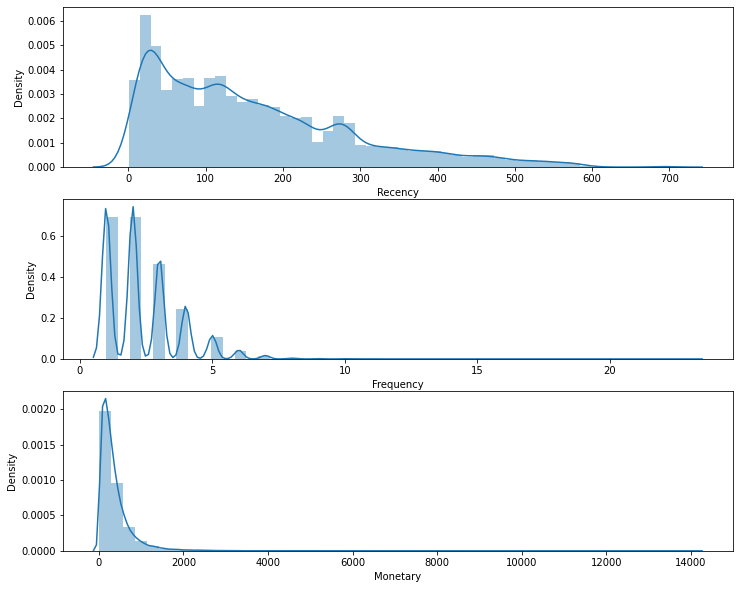

In [23]:
plt.figure(figsize=(12,10))
# Plot distribution of Recency
plt.subplot(3, 1, 1)
sns.distplot(data_process['Recency'])
# Plot distribution of Frequency
plt.subplot(3, 1, 2)
sns.distplot(data_process['Frequency'])
# Plot distribution of Monetary
plt.subplot(3, 1, 3)
sns.distplot(data_process['Monetary'])
# Show the plot
plt.show()

In [24]:
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 4)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels, duplicates='drop')
# Create new columns R and F 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process.head()

,Recency,Frequency,Monetary,R,F
customer_unique_id,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,170,2,136.26,2,1
0000f46a3911fa3c0805444483337064,126,3,583.87,3,2
0004bd2a26a76fe21f786e4fbd80607f,8,3,336.11,4,2
00050ab1314c0e55a6ca13cf7181fecf,220,1,80.18,2,1
0005ef4cd20d2893f0d9fbd94d3c0d97,482,1,187.91,1,1


In [25]:
# Create labels for Monetary Value
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['Monetary'], q=4, labels=m_labels)
# Create new column M
data_process = data_process.assign(M = m_groups.values)

In [26]:
data_process

,Recency,Frequency,Monetary,R,F,M
customer_unique_id,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,170,2,136.26,2,1,2
0000f46a3911fa3c0805444483337064,126,3,583.87,3,2,4
0004bd2a26a76fe21f786e4fbd80607f,8,3,336.11,4,2,3
00050ab1314c0e55a6ca13cf7181fecf,220,1,80.18,2,1,1
0005ef4cd20d2893f0d9fbd94d3c0d97,482,1,187.91,1,1,2
...,...,...,...,...,...,...
fffa431dd3fcdefea4b1777d114144f2,163,3,1643.43,2,2,4
fffb09418989a0dbff854a28163e47c6,294,1,329.38,1,1,3
fffbf87b7a1a6fa8b03f081c5f51a201,52,2,199.50,4,1,2


In [27]:
data_process.M.value_counts()

1    10365
4    10358
3    10357
2    10351
Name: M, dtype: int64

**Note: Run this cell below twice**

In [34]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): 
    return str(x['R']) + str(x['F']) + str(x['M'])

data_process['RFM_Segment'] = data_process.apply(join_rfm, axis=1).astype(str)
rfm = data_process
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,170,2,136.26,2,1,2,212,5
0000f46a3911fa3c0805444483337064,126,3,583.87,3,2,4,324,9
0004bd2a26a76fe21f786e4fbd80607f,8,3,336.11,4,2,3,423,9
00050ab1314c0e55a6ca13cf7181fecf,220,1,80.18,2,1,1,211,4
0005ef4cd20d2893f0d9fbd94d3c0d97,482,1,187.91,1,1,2,112,4


In [29]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment')['RFM_Segment'].nunique()
rfm_count_unique.sum()

48

In [30]:
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
rfm['RFM_Score'].head()

customer_unique_id
0000b849f77a49e4a4ce2b2a4ca5be3f    5
0000f46a3911fa3c0805444483337064    9
0004bd2a26a76fe21f786e4fbd80607f    9
00050ab1314c0e55a6ca13cf7181fecf    4
0005ef4cd20d2893f0d9fbd94d3c0d97    4
Name: RFM_Score, dtype: int64

Segmentation using RFM Analysis | Identify Upselling and Cross selling opportunities

In [31]:
def rfm_level(df):
    if (df['RFM_Segment'] >= 434 or (df['RFM_Score'] >= 9)) :
        return 'VVIP - Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['M'] == 4)):
        return 'Champions Big Spenders'
    elif ((df['RFM_Score'] >= 6) and (df['F'] >= 2)):
        return 'Loyal Customers'
    elif ((df['RFM_Segment'] >= 221) or (df['RFM_Score'] >= 6)):
        return 'Potential Loyalists'
    elif (((df['RFM_Segment'] >= 121) and (df['R'] == 1)) or df['RFM_Score'] == 5):
        return 'Needs Attention'
    elif ((df['RFM_Score'] >= 4) and (df['R'] == 1)):
        return 'Hibernating - Almost Lost'
    else:
        return 'Lost Customers'

In [32]:
# Define rfm_level function
def rfm_action(df):
    if (df['RFM_Segment'] >= 434 or (df['RFM_Score'] >= 9)) :
        return 'No Price Incentives; Offer Limited edition and Loyality programs'
    elif ((df['RFM_Score'] >= 8) and (df['M'] == 4)):
        return 'Upsell most expensive items'
    elif ((df['RFM_Score'] >= 6) and (df['F'] >= 2)):
        return 'Loyality programs;Cross Sell'
    elif ((df['RFM_Segment'] >= 221) or (df['RFM_Score'] >= 6)):
        return 'Cross Sell Recommendations and Discount coupons'
    elif (((df['RFM_Segment'] >= 121) and (df['R'] == 1)) or df['RFM_Score'] == 5):
        return 'Price incentives and Limited time offer'
    elif ((df['RFM_Score'] >= 4) and (df['R'] == 1)):
        return 'Aggressive price incentives'
    else:
        return 'Don\'t spend too much trying to re-acquire'

In [35]:
# Create a new variable RFM_Level
rfm['RFM_Segment'] = rfm.RFM_Segment.apply(lambda x: int(x))
rfm['Customer Segment'] = rfm.apply(rfm_level, axis=1)
# Create a new variable RFM_Level
rfm['Marketing Action'] = rfm.apply(rfm_action, axis=1)
rfm.head(10)

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Customer Segment,Marketing Action
customer_unique_id,,,,,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,170,2,136.26,2,1,2,212,5,Needs Attention,Price incentives and Limited time offer
0000f46a3911fa3c0805444483337064,126,3,583.87,3,2,4,324,9,VVIP - Can't Loose Them,No Price Incentives; Offer Limited edition and...
0004bd2a26a76fe21f786e4fbd80607f,8,3,336.11,4,2,3,423,9,VVIP - Can't Loose Them,No Price Incentives; Offer Limited edition and...
00050ab1314c0e55a6ca13cf7181fecf,220,1,80.18,2,1,1,211,4,Lost Customers,Don't spend too much trying to re-acquire
0005ef4cd20d2893f0d9fbd94d3c0d97,482,1,187.91,1,1,2,112,4,Hibernating - Almost Lost,Aggressive price incentives
000949456b182f53c18b68d6babc79c1,106,1,116.90,3,1,1,311,5,Potential Loyalists,Cross Sell Recommendations and Discount coupons
000a5ad9c4601d2bbdd9ed765d5213b3,168,1,462.72,2,1,4,214,7,Potential Loyalists,Cross Sell Recommendations and Discount coupons
000c8bdb58a29e7115cfc257230fb21b,227,2,852.54,2,1,4,214,7,Potential Loyalists,Cross Sell Recommendations and Discount coupons
000de6019bb59f34c099a907c151d855,24,1,96.66,4,1,1,411,6,Potential Loyalists,Cross Sell Recommendations and Discount coupons


Group Customer by their Customer Segment

In [36]:
# Calculate average values for each Customer Segment, and return a size of each segment 
rfm_level_agg = rfm.groupby('Customer Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'],
    'Marketing Action': 'unique'
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                          Recency Frequency Monetary         \
                             mean      mean     mean  count   
Customer Segment                                              
Champions Big Spenders      160.5       2.8    816.2   1563   
Hibernating - Almost Lost   349.1       1.4    188.0   2541   
Lost Customers              298.5       1.2     78.2   6856   
Loyal Customers             148.6       3.2    319.8   5335   
Needs Attention             245.6       1.8    241.5   3735   
Potential Loyalists         102.8       1.6    279.4  11492   
VVIP - Can't Loose Them      61.6       4.0    716.5   9909   

                                                            Marketing Action  
                                                                      unique  
Customer Segment                                                              
Champions Big Spenders                         [Upsell most expensive items]  
Hibernating - Almost Lost                      [Aggre

In [37]:
rfm_level_ag = pd.DataFrame(rfm_level_agg)
rfm_level_ag = rfm_level_ag.reset_index()
rfm_level_ag

Customer Segment Recency Frequency Monetary         \
                                mean      mean     mean  count   
0     Champions Big Spenders   160.5       2.8    816.2   1563   
1  Hibernating - Almost Lost   349.1       1.4    188.0   2541   
2             Lost Customers   298.5       1.2     78.2   6856   
3            Loyal Customers   148.6       3.2    319.8   5335   
4            Needs Attention   245.6       1.8    241.5   3735   
5        Potential Loyalists   102.8       1.6    279.4  11492   
6    VVIP - Can't Loose Them    61.6       4.0    716.5   9909   

                                    Marketing Action  
                                              unique  
0                      [Upsell most expensive items]  
1                      [Aggressive price incentives]  
2        [Don't spend too much trying to re-acquire]  
3                     [Loyality programs;Cross Sell]  
4          [Price incentives and Limited time offer]  
5  [Cross Sell Recommendations and Discount coupons]  
6  [No Price Incentives; Offer Limited edition an...

From here, we can see that a sufficient percentage (~45%) of our customers are in the top tier RFM levels. Olist must be doing something right to be maintaining their loyalty! The other 55% will need some work.

**1. Potential Loyalists —**


High potential to enter our loyal customer segments, why not throw in some freebies on their next purchase to show that you value them!



**2. Needs Attention —**


Showing promising signs with quantity and value of their purchase but it has been a while since they last bought sometime from you. Let’s target them with their wishlist items and a limited time offer discount.



**3. Hibernating Almost Lost —**


Made some initial purchase but have not seen them since. Was it a bad customer experience? Or product-market fit? Let’s spend some resource build our brand awareness with them.

**4. Lost Customers —**

Poorest performers of our RFM model. They might have went with our competitors for now and will require a different activation strategy to win them back.



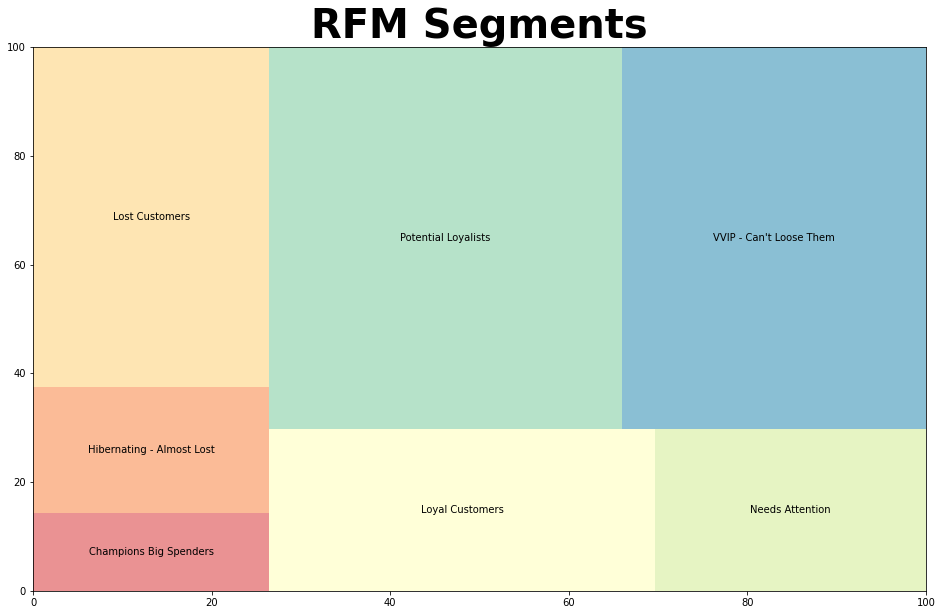

In [38]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count', 'MarketingAction']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Champions Big Spenders',
                     'Hibernating - Almost Lost',
                     'Lost Customers',
                     'Loyal Customers',
                     'Needs Attention',
                     'Potential Loyalists',
                     'VVIP - Can\'t Loose Them'], alpha=.6, 
                      color=sns.color_palette("Spectral", 
                                     len(rfm_level_agg)))
plt.title("RFM Segments",fontsize=40,fontweight="bold")
plt.axis('on')
plt.show()

**Interactive Chart for Visualising Customer Segments**

In [39]:
import plotly.graph_objects as go

fig =go.Figure(go.Treemap(
    labels = rfm_level_ag['Customer Segment'],
    parents = ['Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation'],   #rfm_level_ag[('Marketing Action', 'unique')].tolist(), 
    values= rfm_level_ag[('Monetary', 'count')]
))

fig.show()

# **4. K-means**

Let's apply a machine learning approach to identify if there are any hidden segments we can find from clusters

In [40]:
data_rfm = data_process[['Recency', 'Frequency', 'Monetary']]
data_rfm.min()

Recency      1.00
Frequency    1.00
Monetary     9.59
dtype: float64

In [41]:
data_log = np.log(data_rfm)
scaler = StandardScaler()
scaler.fit(data_log)
data_normalized = scaler.transform(data_log)
data_normalized = pd.DataFrame(data=data_normalized, index=data_rfm.index, columns=data_rfm.columns)

In [42]:
kmeans = KMeans(n_clusters=5, random_state=1) 
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_
data_rfm_k5 = data_rfm.assign(Cluster=cluster_labels)
grouped = data_rfm_k5.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(1)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0          33.5       1.6    182.1   4668
1         276.3       1.0    109.0  10121
2         198.4       2.1    282.6  11910
3         139.8       3.7    708.9   8656
4          26.4       3.8    617.7   6076

To find which ‘k’ value is more suitable for our data we will use **elbow method**.



The elbow method runs k-means clustering on the dataset for a range of values of k.

* Perform K-means clustering with all  these different values of K. For each of the K values, we calculate average distances to the centroid across all data points.

* Plot these points and find the point where the average distance from the centroid falls suddenly (“Elbow”).

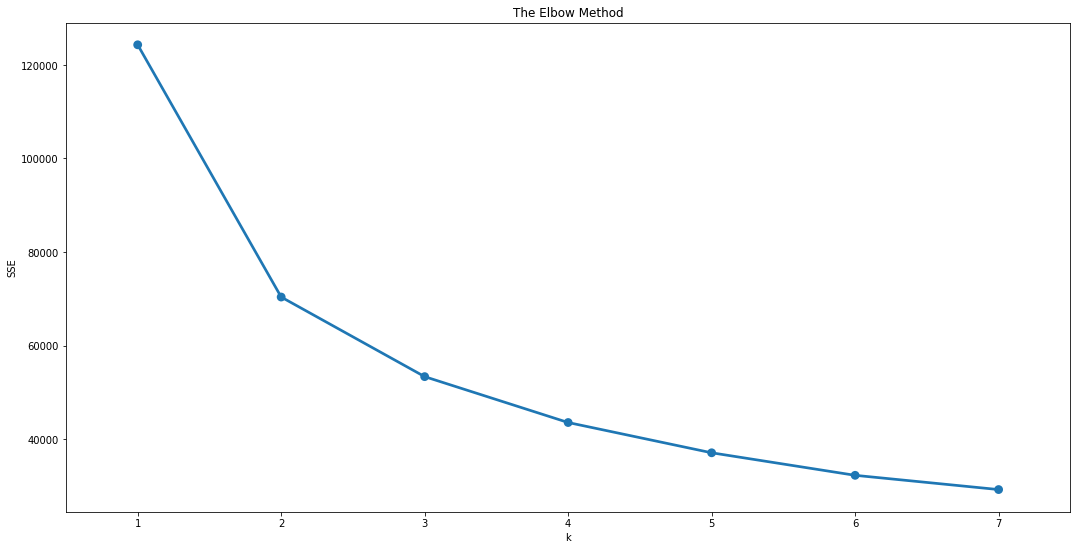

In [43]:
sse = {}
for k in range(1, 8):  
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_
plt.figure(figsize=(18,9))

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [44]:
kmeans = KMeans(n_clusters=4, random_state=1) 
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_
data_rfm_k4 = data_rfm.assign(Cluster=cluster_labels)
grouped = data_rfm_k4.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(1)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0          77.4       4.2    788.9   9284
1         262.3       1.1    113.9  11325
2          27.6       2.2    255.5   6336
3         194.8       2.4    343.5  14486

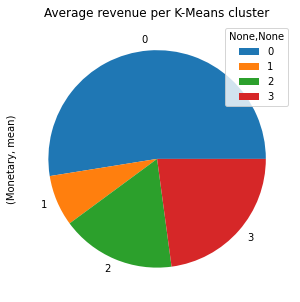

In [45]:
# Plot mean purchase value per K-Means cluster
plt.figure(figsize=(10, 5))
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(1)['Monetary', 'mean'].plot(kind='pie', legend=True)
  
plt.title('Average revenue per K-Means cluster');

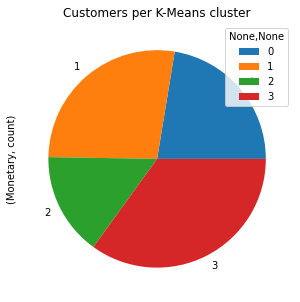

In [46]:
# Plot customers per K-Means cluster
plt.figure(figsize=(10, 5))
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(1)['Monetary', 'count'].plot(kind='pie', legend=True)

plt.title('Customers per K-Means cluster');

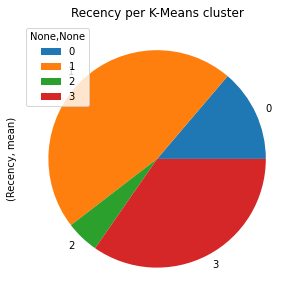

In [47]:
# Plot recency per K-Means cluster
plt.figure(figsize=(10, 5))
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(1)['Recency', 'mean'].plot(kind='pie', legend=True)

plt.title('Recency per K-Means cluster');

In [48]:
data_melt = pd.melt(
                    data_rfm_k4.reset_index(),               
                    id_vars=['customer_unique_id', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'Monetary'], 
                    var_name='Metric', value_name='Value'
                    )
data_melt.head(10)

,customer_unique_id,Cluster,Metric,Value
0,0000b849f77a49e4a4ce2b2a4ca5be3f,3,Recency,170.0
1,0000f46a3911fa3c0805444483337064,0,Recency,126.0
2,0004bd2a26a76fe21f786e4fbd80607f,2,Recency,8.0
3,00050ab1314c0e55a6ca13cf7181fecf,1,Recency,220.0
4,0005ef4cd20d2893f0d9fbd94d3c0d97,1,Recency,482.0
5,000949456b182f53c18b68d6babc79c1,1,Recency,106.0
6,000a5ad9c4601d2bbdd9ed765d5213b3,3,Recency,168.0
7,000c8bdb58a29e7115cfc257230fb21b,3,Recency,227.0
8,000de6019bb59f34c099a907c151d855,2,Recency,24.0
9,000ec5bff359e1c0ad76a81a45cb598f,2,Recency,53.0
